<a href="https://www.kaggle.com/code/arunachal/gcp-basic-data-engineering-workflows-1?scriptVersionId=179988820" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Basic Data Engineering Workflows on Google Cloud Platform - Part 1

### Relevance to current assignment  

The client's analytics needs are to be addressed through Big Query and Looker. However, to obtain high quality tables on BigQuery, careful prior data engineering workflows can be helpful to ensure consistent movement of data across GCP services leading upto BigQuery tables which can be queried and visualised. Below, I highlight five basic workflows which can help generate high quality tables on BigQuery. These workflows:  

a. ingest both batch and streaming datasets from multiple sources (local/SFTP/other databases)  
b. move data across staging and curated buckets based on event-based triggers  
c. finally output the data as BigQuery tables ready for SQL exploration and Looker visualization  

In particular, they attempt to:

b. demonstrate multiple tools achieving the same purpose and offer choices depending on client's use cases  
c. make liberal use of event-based triggers to move data from one location or format to another  
d. allow customization of codes to include non-trivial transformations during data movement  
e. are implemented entirely through CLI and are scalable to huge datasets    

Finally, we conclude by creating an **ETL pipeline for a financial dataset from MSSQL server (hosted on AWS) to BigQuery table**.

#### ***Note***

1. Two datasets are used, merely as an example, to illustrate the workflows: Yelp and Covid datasets (links included).
2. Two workflows related to Composer are facing issues in environment creation because of free tier limits. The ticket to increase quota limits awaits resolution. These two workflows will be updated in a later version of this document.


### Tools: 

#### **GCP**: Deployment Manager, Dataproc, Composer, Dataflow, PubSub, Cloud Functions, Compute (VM), BigQuery, GCS

#### **External**: MSSQL Server, SSMS, AWS-RDS, 

#### **Frameworks**: Apache NiFi, PySpark, Jinja

#### *Standard templates are customized for project needs at various steps.*

##### Credits for standard templates:   
a. GCP Documentations  
b. https://www.projectpro.io/

## Basic GCP Set-up

#### 1. Create a project, a service account, bind to project as editor, generate and store keys at a safe location. Set key as default credentials.

gcloud init --no-launch-browser

gcloud projects create gcloud-etl-422807 --set-as-default

gcloud iam service-accounts create gcloud-etl-service-account 

gcloud projects add-iam-policy-binding gcloud-etl-422807 \
  --member="serviceAccount:gcloud-etl-service-account@gcloud-etl-422807.iam.gserviceaccount.com" \
  --role="roles/editor"

gcloud iam service-accounts keys create key.json --iam-account=gcloud-etl-service-account@gcloud-etl-422807.iam.gserviceaccount.com

gcloud auth activate-service-account gcloud-etl-service-account@gcloud-etl-422807.iam.gserviceaccount.com --key-file=key.json

gcloud auth list

set GOOGLE_APPLICATION_CREDENTIALS=~/Programming/Projects/GCP Data Ingestion with SQL using Google Cloud Dataflow/key.json

#### 2. Set project as default project and a quota project. Enable APIs: Cloud Composer, PubSub, Dataflow, BigQuery, BigTable and all required APIs. 

gcloud config set project gcloud-etl-422807

gcloud auth application-default set-quota-project gcloud-etl-422807

gcloud services list --available

gcloud services enable composer.googleapis.com  dataflow.googleapis.com 

#### 3. Install beam, pubsub.

pip install apache-beam[gcp]  
pip install google-cloud-pubsub

#### The first two workflows can be broadly summarised as below.

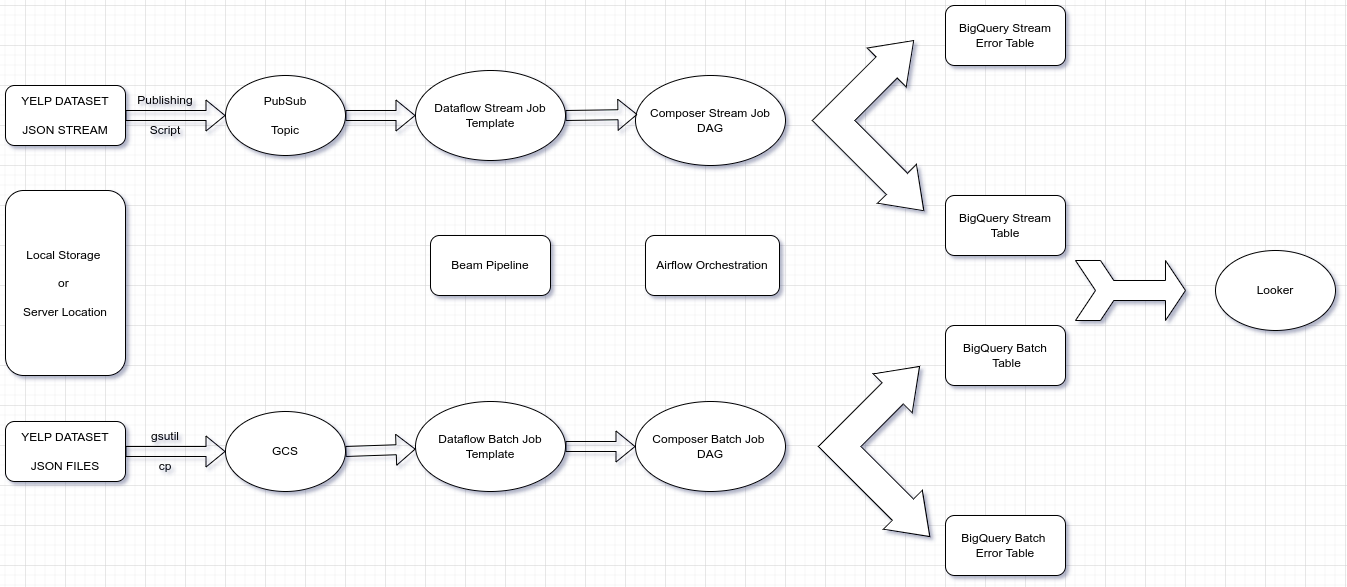

## Workflow 1: Create a stream pipeline from local machine to PubSub and push data using Composer-orchestrated Dataflow jobs to Big Query and Looker

#### 4. Create GCS bucket for yelp-covid dataset (to be used as a stream job) and copy data from local to bucket.

gcloud storage buckets create gs://yelp-covid

gsutil cp yelp_academic_dataset_covid_features.json gs://yelp-covid/data/

**or with multi-threading option:**

gsutil cp -m *.json gs://yelp-covid/data/  
gsutil ls gs://yelp-covid/data/

#### 5. Create PubSub topic and subscriptions. Publish yelp-covid data as a stream from local to PubSub.

gcloud pubsub topics create yelp-covid

gcloud pubsub subscriptions create yelp-covid-sub --topic yelp-covid

#### 6. Create a config file and customize python script to publish messages from local to PubSub topic. Create the config file as follows:

[gcp]  
project_id = gcloud-etl-422807  
topic_id = yelp-covid  
credentials_path = /home/arunachal/Programming/Projects/GCP Data Ingestion with SQL using Google Cloud Dataflow/key.json  
file_path = /home/arunachal/Programming/Projects/GCP Data Ingestion with SQL using Google Cloud   Dataflow/Data/yelp_academic_dataset_covid_features.json  

#### Customize the python template below to publish messages from local to PubSub topic.

In [ ]:
# -*- coding: utf-8 -*-

import time#,os,json
import argparse
from google.cloud import pubsub_v1
from google.oauth2 import service_account
from configparser import ConfigParser


def get_callback(f, data):
    def callback(f):
        try:
            print(f.result())
            futures.pop(data)
        except:  # noqa
            print("Please handle {} for {}.".format(f.exception(), data))

    return callback

def publish(filepath):
    
    with open(filepath,encoding="utf8") as openfileobject:
        for line in openfileobject:
            
            '''dict1 = json.loads(line)
            #dict2 = {}
            #dict2["business_id"] = dict1['business_id']
            #dict2["highlights"]=dict1['highlights']
            dict2 = {x.replace(' ', '_'): v 
                     for x, v in dict1.items()}
            data = str(dict2)
            futures.update({data: None})'''
            
            data = line
            futures.update({data: None})
            
            # On publishing a message, the client returns a future.
            future = publisher.publish(topic=topic_path, data=data.encode("utf-8"))
            futures[data] = future
            
            # Publish failures are handled in the callback function.
            future.add_done_callback(get_callback(future, data))
    
    # Waiting for all the publish futures to resolve before exiting.
    while futures:
        time.sleep(5)
    
    print("Published messages with error handler to "+topic_path)

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument(
        '--config_path', required=True,
        help='Config path from where config will be read.')
    args = parser.parse_args()
    #print(args.config_path)
    config = ConfigParser()
    config.read(args.config_path)
    #print (config.get('gcp','credentials_path'))
    
    credentials = service_account.Credentials.from_service_account_file(
        config.get('gcp','credentials_path'))
    

    project_id = config.get('gcp','project_id')
    topic_id = config.get('gcp','topic_id')
    
    publisher = pubsub_v1.PublisherClient(credentials=credentials)
    topic_path = publisher.topic_path(project_id, topic_id)
    futures = dict()
    publish(config.get('gcp','file_path'))

The publishing script:

a. Imports libraries time, argparse, google.cloud.pubsub_v1, google.oauth2.service_account, configparser.ConfigParser.

b. Takes as argument config_path which specifies 4 arguments: credentials_path, project_id, topic_id, file_path. ConfigParser object extracts these values from config file using .get method.

c. uses pubsub_v1 and credentials to create publisher client object and topic path.

d. reads each line of the data file, publishes to PubSub, updates futures dict and gets callback.

#### Run the python script from local alongwith the path to the config file.

python3 Codes/Python/publish_messages.py --config_path=Codes/Database/publish_config.ini

#### 6. Next, push the messages received in PubSub subscriptions to a BQ table using a Beam job with Dataflow as a runner.  

#### For this, create a GCS bucket for Dataflow jobs.

gcloud storage buckets create gs://gcp-yelp-dataflow  

#### Within the bucket, create subfolders **staging** and **temp**. Create a BQ dataset within which Dataflow will create tables for streaming data and error logs.

bq mk --dataset yelp_tables

#### Customize the Beam template below to create a Dataflow job which pushes the messages from PubSub subscription to a BQ table.

In [ ]:
# -*- coding: utf-8 -*-

"""An Apache Beam streaming pipeline example.
It reads JSON encoded messages from Pub/Sub, transforms the message data and
writes the results to BigQuery.
"""

import argparse
import json
import logging
#import time
from apache_beam.io.gcp.bigquery_tools import RetryStrategy
import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions
#from apache_beam.options.pipeline_options import SetupOptions
#import apache_beam.transforms.window as window

# Defines the BigQuery schema for the output table.
SCHEMA = ','.join([
    'business_id:STRING',
    'highlights:STRING',
    'delivery_or_takeout:STRING',
    'Grubhub_enabled:STRING',
    'Call_To_Action_enabled:STRING',
    'Request_a_Quote_Enabled:STRING',
    'Covid_Banner:STRING',
    'Temporary_Closed_Until:STRING',
    'Virtual_Services_Offered:STRING',
])

ERROR_SCHEMA = ','.join([
    'error:STRING',
])


class ParseMessage(beam.DoFn):
    OUTPUT_ERROR_TAG = 'error'    
    def process(self, line):
        """
        Extracts fields from json message
        :param line: pubsub message
        :return: have two outputs:
            - main: parsed data
            - error: error message
        """
        try:
            parsed_row = json.loads(line) # parse json message to corresponding bgiquery table schema
            print("Running")
            logging.info("Running")
            yield {
                 'business_id': parsed_row['business_id'],
                 'highlights': parsed_row['highlights'],
                 'delivery_or_takeout': parsed_row['delivery or takeout'],
                 'Grubhub_enabled': parsed_row['Grubhub enabled'],
                 'Call_To_Action_enabled': parsed_row['Call To Action enabled'],
                 'Request_a_Quote_Enabled': parsed_row['Request a Quote Enabled'],
                 'Covid_Banner': parsed_row['Covid Banner'],
                 'Temporary_Closed_Until': parsed_row['Temporary Closed Until'],
                 'Virtual_Services_Offered': parsed_row['Virtual Services Offered']
                 }
        except Exception as error:
            print("error")
            logging.info("error")
            error_row = { 'error': str(error) }
            yield beam.pvalue.TaggedOutput(self.OUTPUT_ERROR_TAG, error_row)

class DataflowOptions(PipelineOptions):

    @classmethod
    def _add_argparse_args(cls, parser):
        parser.add_argument(
        '--input_subscription',default="projects/gcloud-etl-422807/subscriptions/yelp-covid-sub",
        help='Input PubSub subscription of the form "/subscriptions/<PROJECT>/<SUBSCRIPTION>".')
        parser.add_argument(
            '--output_table', type=str,default='gcloud-etl-422807:yelp_tables.yelp_covid_table',
            help='Output BigQuery table for results specified as: PROJECT:DATASET.TABLE or DATASET.TABLE.')
        parser.add_argument(
            '--output_error_table', type=str,default='gcloud-etl-422807:yelp_tables.yelp_covid_error_table',
            help='Output BigQuery table for errors specified as: PROJECT:DATASET.TABLE or DATASET.TABLE.')

def run(argv=None):
    """Build and run the pipeline."""
    #options = PipelineOptions(args, save_main_session=True, streaming=True)
    parser = argparse.ArgumentParser(argv)    
    known_args, pipeline_args = parser.parse_known_args(argv)
    options = PipelineOptions(pipeline_args, save_main_session=True, streaming=True)
    dataflow_options = options.view_as(DataflowOptions)
    
    with beam.Pipeline(options=options) as pipeline:
        # Read the messages from PubSub and process them.
        rows, error_rows = (
            pipeline
            | 'Read from Pub/Sub' >> beam.io.ReadFromPubSub(
                subscription=str(dataflow_options.input_subscription)).with_output_types(bytes)
            | 'UTF-8 bytes to string' >> beam.Map(lambda msg: msg.decode('utf-8'))
            | 'Parse JSON messages' >> beam.ParDo(ParseMessage()).with_outputs(ParseMessage.OUTPUT_ERROR_TAG,
                                                                                main='rows')
             )
        # Output the results into BigQuery table.
        _ = (rows | 'Write to BigQuery'
             >> beam.io.WriteToBigQuery(table=dataflow_options.output_table,
                                        schema=SCHEMA,
                                        create_disposition=beam.io.BigQueryDisposition.CREATE_IF_NEEDED,
                                        write_disposition=beam.io.BigQueryDisposition.WRITE_APPEND,
                                        insert_retry_strategy=RetryStrategy.RETRY_ON_TRANSIENT_ERROR
                                        )
             )

        _ = (error_rows | 'Write errors to BigQuery'
             >> beam.io.WriteToBigQuery(table=dataflow_options.output_error_table,
                                        schema=ERROR_SCHEMA,
                                        create_disposition=beam.io.BigQueryDisposition.CREATE_IF_NEEDED,
                                        write_disposition=beam.io.BigQueryDisposition.WRITE_APPEND,
                                        insert_retry_strategy=RetryStrategy.RETRY_ON_TRANSIENT_ERROR
                                        )
             )


if __name__ == '__main__':
    logging.getLogger().setLevel(logging.INFO)
    #known_args, pipeline_args = parser.parse_known_args()
    run()



The script:

a. imports argparse, json, logging, apache.beam, apache_beam.io.gcp.bigquery_tools.RetryStrategy, apache_beam.options.pipeline_options.PipelineOptions

b. specifies schema for yelp-covid streaming dataset and error schema.

c. Creates a Beam pipeline which 

i. reads messages from PubSub  
ii. converts utf-8 bytes in message to string  
iii. parses json messages line by line and organizes as per specified BQ table schema with logs  
iv. writes to BQ  

#### Create a GCS bucket to place Dataflow templates which will be auto-generated by the running the above code. Then, run the above script with appopriate Dataflow arguments as below to automatically generate a Dataflow template for the stream job and place in the specified bucket.

gcloud storage buckets create gs://yelp-airflow-templates  

python3 Codes/Python/dataflow_stream_templated.py --runner DataflowRunner --region us-west1 --project gcloud-etl-422807 --staging_location gs://gcp-yelp-dataflow/staging --temp_location gs://gcp-yelp-dataflow/temp --job_name yelp-stream-bq-test --num_workers 1 --max_num_workers 6 --template_location gs://yelp-airflow-templates/streamtemplate --save_main_session True

#### The template file can now be seen as gs://yelp-airflow-templates/streamtemplate. Dataflow will use this template alongwith a similar one for batch job together at a later stage.

## Workflow 2: Create a batch pipeline from local machine to GCS and push data using Composer-orchestrated Dataflow jobs to Big Query and Looker

#### 7. Download yelp-business data for batch pipeline: https://www.kaggle.com/datasets/yelp-dataset/yelp-dataset/data?select=yelp_academic_dataset_business.json

#### Create a GCS bucket and transfer business data from local.

gcloud storage buckets create gs://yelp-academic  
gsutil cp yelp_academic_dataset_business.json gs://yelp-academic/data/

#### 8. Push business data from GCS to BQ using the customized Dataflow job template below.

In [ ]:
# -*- coding: utf-8 -*-


"""An Apache Beam batch pipeline example.
It reads JSON encoded messages from GCS file, transforms the message data and
writes the results to BigQuery.
"""

import argparse
import json
import logging
#import time
from apache_beam.io.gcp.bigquery_tools import RetryStrategy
import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions
#from apache_beam.options.pipeline_options import SetupOptions
#import apache_beam.transforms.window as window

# Defines the BigQuery schema for the output table.
REVIEW_SCHEMA = ','.join([
    'review_id:STRING',
    'user_id:STRING',
    'business_id:STRING',
    'stars:INT64',
    'date:STRING',
    'text:STRING',
    'useful:INT64',
    'funny:INT64',
    'cool:INT64',
])

ERROR_SCHEMA = ','.join([
    'error:STRING',
])

review_schema = {
    'fields': [{
        'name': 'review_id', 'type': 'STRING', 'mode': 'REQUIRED'
    }, {
        'name': 'user_id', 'type': 'STRING', 'mode': 'REQUIRED'
    },
    {
        'name': 'business_id', 'type': 'STRING', 'mode': 'REQUIRED'
    }, {
        'name': 'stars', 'type': 'FLOAT64', 'mode': 'NULLABLE'
    },
     {
        'name': 'date', 'type': 'STRING', 'mode': 'NULLABLE'
    }, {
        'name': 'text', 'type': 'STRING', 'mode': 'NULLABLE'
    },
    {
        'name': 'useful', 'type': 'INT64', 'mode': 'NULLABLE'
    }, {
        'name': 'funny', 'type': 'INT64', 'mode': 'NULLABLE'
    },
     {
        'name': 'cool', 'type': 'INT64', 'mode': 'NULLABLE'
    }]
}

business_schema1 = {
    'fields': [{
        'name': 'business_id', 'type': 'STRING', 'mode': 'REQUIRED'
    }]}

business_schema = {
    'fields': [{
        'name': 'business_id', 'type': 'STRING', 'mode': 'REQUIRED'
    }, {
        'name': 'name', 'type': 'STRING', 'mode': 'NULLABLE'
    },
    {
        'name': 'address', 'type': 'STRING', 'mode': 'NULLABLE'
    }, {
        'name': 'city', 'type': 'STRING', 'mode': 'NULLABLE'
    },
     {
        'name': 'state', 'type': 'STRING', 'mode': 'NULLABLE'
    }, {
        'name': 'postal_code', 'type': 'STRING', 'mode': 'NULLABLE'
    },
    {
        'name': 'latitude', 'type': 'FLOAT64', 'mode': 'NULLABLE'
    }, {
        'name': 'longitude', 'type': 'FLOAT64', 'mode': 'NULLABLE'
    },
     {
        'name': 'stars', 'type': 'FLOAT64', 'mode': 'NULLABLE'
    },
    {
        'name': 'review_count', 'type': 'INT64', 'mode': 'NULLABLE'
    },
     {
        'name': 'is_open', 'type': 'INT64', 'mode': 'NULLABLE'
    },
    {
        'name': 'categories', 'type': 'STRING', 'mode': 'NULLABLE'
    }
     ,{
        'name': 'hours', 'type': 'RECORD', 'mode': 'NULLABLE',"fields": [
            {
                "name": "Monday",
                "type": "STRING"
            },
            {
                "name": "Tuesday",
                "type": "STRING"
            },
            {
                "name": "Friday",
                "type": "STRING"
           },
            {
                "name": "Wednesday",
                "type": "STRING"
            },
            {
               "name": "Thursday",
                "type": "STRING"
           },
           {
               "name": "Sunday",
                "type": "STRING"
            },
            {
                "name": "Saturday",
                "type": "STRING"
            }
        ]
    }
    ]
}

class ParseMessage(beam.DoFn):
    OUTPUT_BUSINESS_TAG = 'business' 
    OUTPUT_ERROR_TAG = 'error'
    def process(self, element,table):
        """
        Extracts fields from json message
        :param element: file metadata message returned from reading files at input path.
        :return: have two outputs:
            - reviews: parsed review data
            - business: parsed business data
        """
        try:
            line = json.loads(element)
            print(line)
            logging.info(line)
            if 'review' in table:
                review = {
                        'review_id': line['review_id'],
                        'user_id': line['user_id'],
                        'business_id': line['business_id'],
                        'stars': line['stars'],
                        'date': line['date'],
                        'text': line['text'],
                        'useful': line['useful'],
                        'funny': line['funny'],
                        'cool': line['cool']
                        }
                print(review)
                logging.info(review)
                
                yield review
            else:
                business =  {
                        'business_id': line['business_id'],
                        'name': line['name'] ,
                        'address': line['address'] ,
                        'city': line['city'] ,
                        'state': line['state'] ,
                        'postal_code': line['postal_code'] ,
                        'latitude': line['latitude'],
                        'longitude': line['longitude'],
                        'stars': line['stars'],
                        'review_count': line['review_count'],
                        'is_open': line['is_open'],
                        'categories': line['categories'],
                        'hours': line['hours']
                        }
                print(business)
                logging.info(business)
                #yield beam.pvalue.TaggedOutput(self.OUTPUT_BUSINESS_TAG, business)
                yield business
        except Exception as error:
            print("error")
            logging.info(str(error))
            error_row = { 'error': str(error) }
            yield beam.pvalue.TaggedOutput(self.OUTPUT_ERROR_TAG, error_row)

class DataflowOptions(PipelineOptions):

    @classmethod
    def _add_argparse_args(cls, parser):
        parser.add_value_provider_argument(
        '--input_path', type=str,default='gs://yelp-academic/data/*',
        help='Input GCS path from where files will be read.')
        parser.add_value_provider_argument(
            '--table', type=str,default='gcloud-etl-422807:yelp_tables.yelp_business_table',
            help='Output BigQuery table for file specified as: PROJECT:DATASET.TABLE or DATASET.TABLE.')
        parser.add_value_provider_argument(
            '--error_table', type=str,default='gcloud-etl-422807:yelp_tables.yelp_business_error_table',
            help='Output BigQuery table for error as: PROJECT:DATASET.TABLE or DATASET.TABLE.')
        
def run(argv=None):
    """Build and run the pipeline."""
    parser = argparse.ArgumentParser(argv)    
    known_args, pipeline_args = parser.parse_known_args()
    options = PipelineOptions(pipeline_args, save_main_session=True)
    dataflow_options = options.view_as(DataflowOptions)
    with beam.Pipeline(options=options) as pipeline: 
        rows, error = (
            pipeline
            | beam.io.ReadFromText(dataflow_options.input_path)
            | 'Parse JSON messages' >> beam.ParDo(ParseMessage(),dataflow_options.table).with_outputs(ParseMessage.OUTPUT_ERROR_TAG,
                                                                                main='rows')
             )
           

        # Output the results into BigQuery table.
        _ = (rows | 'Write rows to BigQuery'
             >> beam.io.WriteToBigQuery(table=dataflow_options.table,
                                        schema=lambda table: (business_schema
                                                              if 'business' in table
                                                              else review_schema),
                                        create_disposition=beam.io.BigQueryDisposition.CREATE_IF_NEEDED,
                                        write_disposition=beam.io.BigQueryDisposition.WRITE_APPEND,
                                        #insert_retry_strategy=RetryStrategy.RETRY_ON_TRANSIENT_ERROR
                                        )
             )

        _ = (error | 'Write error to BigQuery'
             >> beam.io.WriteToBigQuery(table=dataflow_options.error_table,
                                        schema=ERROR_SCHEMA,
                                        create_disposition=beam.io.BigQueryDisposition.CREATE_IF_NEEDED,
                                        write_disposition=beam.io.BigQueryDisposition.WRITE_APPEND,
                                        #insert_retry_strategy=RetryStrategy.RETRY_ON_TRANSIENT_ERROR
                                        )
             )


if __name__ == '__main__':
    logging.getLogger().setLevel(logging.INFO)   
    run()

#### The script runs in a similar manner as explained for the stream job before. Execute the above script with appropriate Dataflow arguments as below.

 python3 Codes/Python/dataflow_batch_templated.py --runner DataflowRunner --region us-west1 --project gcloud-etl-422807 --staging_location gs://gcp-yelp-dataflow/staging --temp_location gs://gcp-yelp-dataflow/temp --job_name yelp-batch-business-bq-test --num_workers 1 --max_num_workers 6 --template_location gs://yelp-airflow-templates/batchtemplate --save_main_session True

#### The template file can now be seen as gs://yelp-airflow-templates/batchtemplate. Dataflow will use this template alongwith the similar one for stream job together.

#### 10. Customize the Airflow DAG templates as below for both stream and batch jobs.

In [ ]:
# -*- coding: utf-8 -*-
"""
This is the dag which will be deployed on cloud composer for running stream jobs
"""

from airflow import DAG
#from airflow.operators.python_operator import PythonOperator
from airflow.operators.dummy_operator import DummyOperator
from airflow.contrib.operators.dataflow_operator import DataflowTemplateOperator
from datetime import datetime, timedelta
#from airflow.contrib.hooks.gcs_hook import GoogleCloudStorageHook
#from google.cloud import storage
#from airflow.models import Variable

default_args = {
    'owner': 'airflow',
    'depends_on_past': False,
    'start_date': datetime(2020, 8, 10),
    'email_on_failure': False,
    'email_on_retry': False,
    'retries': 1,
    'retry_delay': timedelta(minutes=5),
}


dag = DAG('Stream_Dataflow_dag',
            catchup=False,
            schedule_interval=None,
            default_args=default_args)


start = DummyOperator(task_id='start',dag=dag)

job = DataflowTemplateOperator(
        task_id='template_stream_job',
        template="gs://yelp-airflow-templates/streamtemplate",
        job_name='job_stream_from_airflow',
        
        dataflow_default_options={
            "project": "gcloud-etl-422807",
            "stagingLocation": "gs://gcp-yelp-dataflow/staging",
            "tempLocation": "gs://gcp-yelp-dataflow/temp",
            "serviceAccountEmail": "gcloud-etl-service-account@gcloud-etl-422807.iam.gserviceaccount.com"},
        #parameters={
         #   "input_subscription": "projects/gcloud-etl-422807/subscriptions/yelp-covid-sub",
          #  "output_table": "gcloud-etl-422807:yelp_tables.yelp_covid_table",
           # "output_error_table": "gcloud-etl-422807:yelp_tables.yelp_covid_error_table"           
        #},
                dag=dag)

start >> job

"""with dag:
    start = DummyOperator(task_id='start')
    t1 = PythonOperator(
        task_id='Pipeline_definition',
        python_callable=upload_pipeline_def)

    start >> t1
    """

In [ ]:
# -*- coding: utf-8 -*-
"""
This is the dag which will be deployed on cloud composer for running batch jobs
"""

from airflow import DAG
#from airflow.operators.python_operator import PythonOperator
from airflow.operators.dummy_operator import DummyOperator
from airflow.contrib.operators.dataflow_operator import DataflowTemplateOperator
from datetime import datetime, timedelta
#from airflow.contrib.hooks.gcs_hook import GoogleCloudStorageHook
#from google.cloud import storage
#from airflow.models import Variable

default_args = {
    'owner': 'airflow',
    'depends_on_past': False,
    'start_date': datetime(2020, 8, 10),
    'email_on_failure': False,
    'email_on_retry': False,
    'retries': 1,
    'retry_delay': timedelta(minutes=5),
}


dag = DAG('Batch_Dataflow_dag',
            catchup=False,
            schedule_interval=None,
            default_args=default_args)


start = DummyOperator(task_id='start',dag=dag)

job = DataflowTemplateOperator(
        task_id='template_test_job',
        template="gs://yelp-airflow-templates/batchtemplate",
        job_name='job_test_from_airflow',
        
        dataflow_default_options={
            "project": "gcloud-etl-422807",
            "stagingLocation": "gs://gcp-yelp-dataflow/staging",
            "tempLocation": "gs://gcp-yelp-dataflow/temp",
            "serviceAccountEmail": "gcloud-etl-service-account@gcloud-etl-422807.iam.gserviceaccount.com"},
        parameters={
            "input_path": "gs://yelp-academic/data/*",
            "table": "gcloud-etl-422807:yelp_tables.yelp_business_table",
            "error_table": "gcloud-etl-422807:yelp_tables.yelp_business_error_table"           
        },
                dag=dag)

start >> job

"""with dag:
    start = DummyOperator(task_id='start')
    t1 = PythonOperator(
        task_id='Pipeline_definition',
        python_callable=upload_pipeline_def)

    start >> t1
    """

#### 11. Copy Airflow DAG templates for dataflow jobs (both streaming and batch) to a newly created GCS bucket.

gcloud storage buckets create gs://yelp-airflow-templates  
gsutil cp template_batch_dag.py template_stream_dag.py gs://us-west1-etl-env-e03dcb3f-bucket/dags/

#### We can test-run the Dataflow jobs from console to find these BQ tables created with stream and batch datasets: 

gcloud-etl-422807:yelp_tables.yelp_covid_table  
gcloud-etl-422807:yelp_tables.yelp_covid_error_table 

gcloud-etl-422807:yelp_tables.yelp_business_table  
gcloud-etl-422807:yelp_tables.yelp_business_error_table

#### 12. To confirm if all rows in both stream and batch jsons are transferred without loss, compare the record counts in BQ tables with those of local jsons using below commands.

wc -l < yelp_academic_dataset_business.json  
wc -l < yelp_academic_dataset_covid_features.json

#### 13. Create a new Composer environment to schedule the DAGs using in-built Airflow libraries.

#### *(To be updated: Facing quota issues in creating Composer 2 environment on GCP. Support ticket for quota increase is yet to be resolved.)* 


#### The next workflows can be summarized using the schematic below.

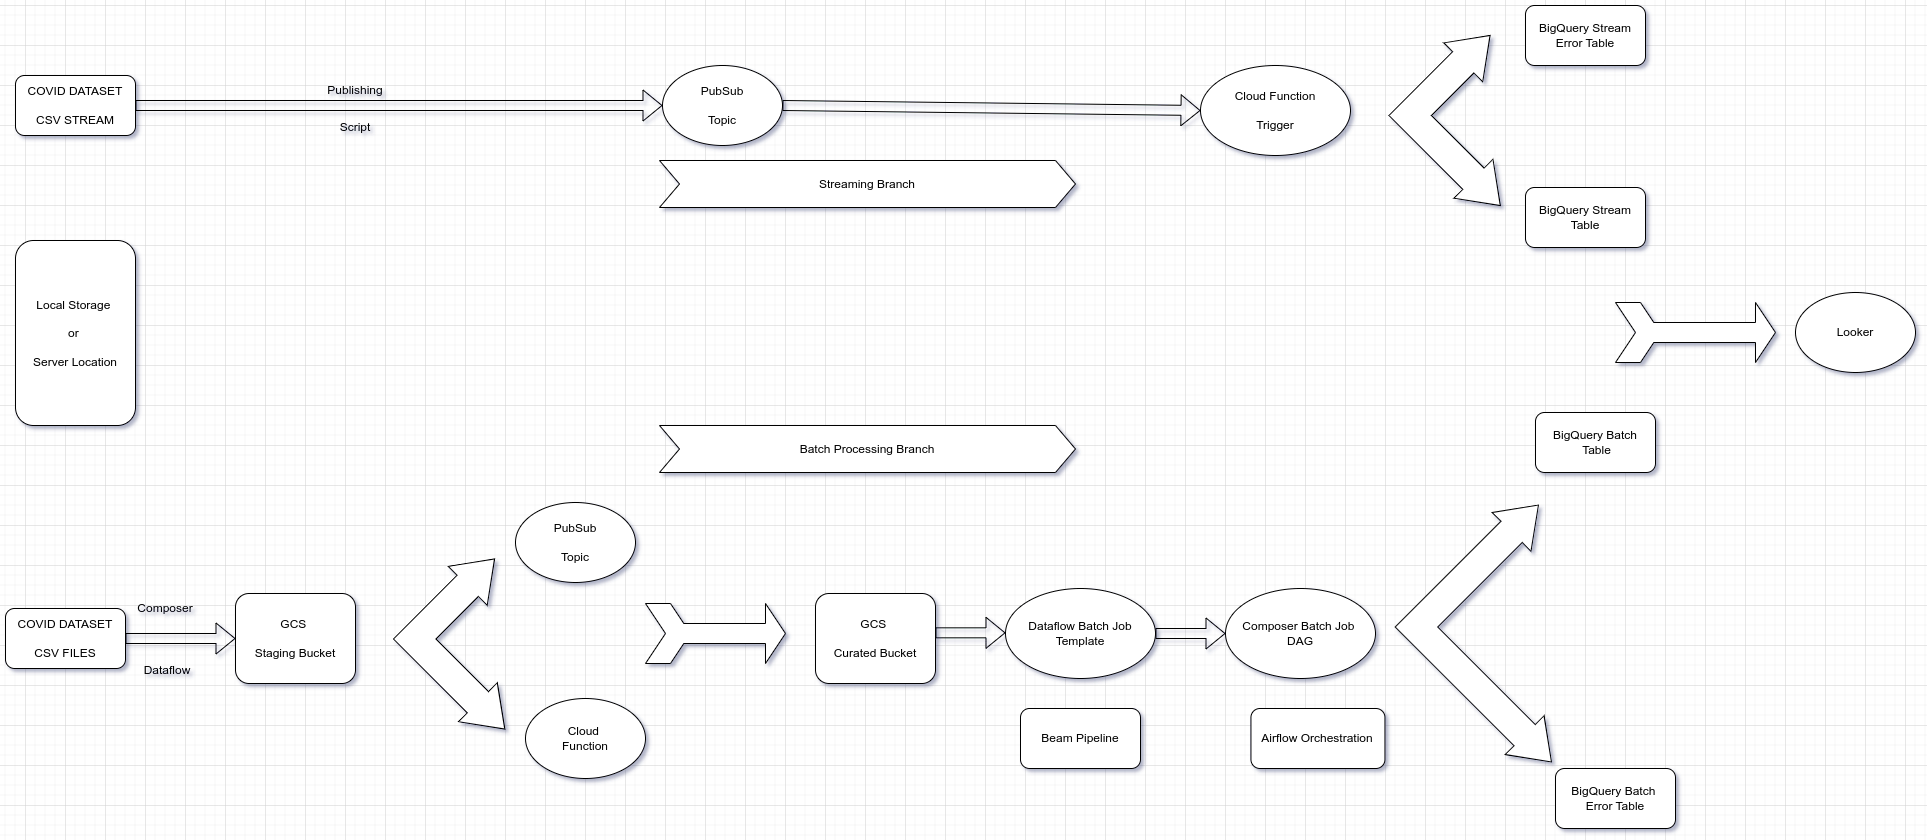

## Workflow 3: Create a stream pipeline from local machine to Big Query and Looker using PubSub and Cloud Functions

#### 1. Download covid_cases dataset from: https://data.world/covid-19-data-resource-hub/covid-19-case-counts/workspace/file?filename=COVID-19+Cases.csv  

#### Sample 2000 records from dataset for streaming purposes.

cat COVID-19\ Cases.csv | wc -l  
head -2000 COVID-19\ Cases.csv > covid_sample.csv


#### 2. Create a PubSub topic

gcloud pubsub topics create covid

#### 3. Create a configuration file which will be used by a customized python template to publish data from local machine to PubSub, with parameters as:

[gcp]  
project_id = gcloud-etl-422807  
topic_id = covid  
credentials_path = /home/arunachal/Programming/Projects/GCP Data Ingestion with SQL using Google Cloud Dataflow/key.json  
file_path = /home/arunachal/Programming/Projects/Build a Scalable Event Based GCP Data Pipeline using DataFlow/data/covid_sample.csv  

#### 4. Customize the template below to publish data from local machine to PubSub.

In [ ]:
# -*- coding: utf-8 -*-
"""
This script publishes the messages by reading the file name specified in config file to pubs topic.
"""

import time#,os,json
import argparse
from google.cloud import pubsub_v1
from google.oauth2 import service_account
from configparser import ConfigParser


def get_callback(f, data):
    def callback(f):
        try:
            print(f.result())
            futures.pop(data)
        except:  # noqa
            print("Please handle {} for {}.".format(f.exception(), data))

    return callback

def publish(filepath):
    
    with open(filepath, encoding="utf8") as openfileobject:
        for i, line in enumerate(openfileobject):
            if i != 0:
                data = line
                futures.update({data: None})
                # When you publish a message, the client returns a future.
                future = publisher.publish(topic=topic_path, data=data.encode("utf-8"))
                futures[data] = future
                # Publish failures shall be handled in the callback function.
                future.add_done_callback(get_callback(future, data))
    
    # Wait for all the publish futures to resolve before exiting.
    while futures:
        time.sleep(5)
    
    print("Published messages with error handler to "+topic_path)

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument(
        '--config_path', required=True,
        help='Config path from where config will be read.')
    args = parser.parse_args()
    #print(args.config_path)
    config = ConfigParser()
    config.read(args.config_path)
    #print (config.get('gcp','credentials_path'))
    
    credentials = service_account.Credentials.from_service_account_file(
        config.get('gcp','credentials_path'))
    
    # TODO(developer)
    project_id = config.get('gcp','project_id')
    topic_id = config.get('gcp','topic_id')
    
    publisher = pubsub_v1.PublisherClient(credentials=credentials)
    topic_path = publisher.topic_path(project_id, topic_id)
    futures = dict()
    publish(config.get('gcp','file_path'))

#### 5. Publish data to PubSub using script

python3 Code/scripts/publish_messages.py --config_path=Installation & Execution/config/publish_config.ini

#### 6. Set up a cloud function to transfer data from PubSub to BQ. This is optimal for small workloads with light-weight transformations.

gcloud functions deploy pubsub_2_bq \
--gen2
--trigger-topic=covid 

#### 7. Create a schema file as below for final tables in BQ.

In [ ]:
[
  {
    "description": "Case_Type",
    "mode": "REQUIRED",
    "name": "Case_Type",
    "type": "STRING"
  },
  {
    "description": "People_Total_Tested_Count",
    "mode": "NULLABLE",
    "name": "People_Total_Tested_Count",
    "type": "STRING"
  },
  {
    "description": "Cases",
    "mode": "NULLABLE",
    "name": "Cases",
    "type": "STRING"
  },
  {
    "description": "Difference",
    "mode": "REQUIRED",
    "name": "Difference",
    "type": "STRING"
  },
  {
    "description": "Date",
    "mode": "NULLABLE",
    "name": "Date",
    "type": "STRING"
  },
  {
    "description": "Combined_Key",
    "mode": "NULLABLE",
    "name": "Combined_Key",
    "type": "STRING"
  },
  {
    "description": "Country_Region",
    "mode": "REQUIRED",
    "name": "Country_Region",
    "type": "STRING"
  },
  {
    "description": "Province_State",
    "mode": "NULLABLE",
    "name": "Province_State",
    "type": "STRING"
  },
  {
    "description": "Admin2",
    "mode": "NULLABLE",
    "name": "Admin2",
    "type": "STRING"
  },
  {
    "description": "iso2",
    "mode": "REQUIRED",
    "name": "iso2",
    "type": "STRING"
  },
  {
    "description": "iso3",
    "mode": "NULLABLE",
    "name": "iso3",
    "type": "STRING"
  },
  {
    "description": "FIPS",
    "mode": "NULLABLE",
    "name": "FIPS",
    "type": "STRING"
  },
  {
    "description": "Lat",
    "mode": "REQUIRED",
    "name": "Lat",
    "type": "STRING"
  },
  {
    "description": "Long",
    "mode": "NULLABLE",
    "name": "Long",
    "type": "STRING"
  },
  {
    "description": "Population_Count",
    "mode": "NULLABLE",
    "name": "Population_Count",
    "type": "STRING"
  },
  {
    "description": "People_Hospitalized_Cumulative_Count",
    "mode": "REQUIRED",
    "name": "People_Hospitalized_Cumulative_Count",
    "type": "STRING"
  },
  {
    "description": "Data_Source",
    "mode": "NULLABLE",
    "name": "Data_Source",
    "type": "STRING"
  },
  {
    "description": "Prep_Flow_Runtime",
    "mode": "NULLABLE",
    "name": "Prep_Flow_Runtime",
    "type": "STRING"
  }
]

#### 8. Create a BQ dataset covid_tables and a table within it by specifying a custom schema file.

bq mk --dataset covid_tables

bq mk --table covid_tables.covid_stream /home/arunachal/Programming/Projects/Build\ a\ Scalable\ Event\ Based\ GCP\ Data\ Pipeline\ using\ DataFlow/Installation\ and\ Execution/config/bq_schema

#### 9. Customize the cloud function template as below.

In [ ]:
"""
Cloud function code to copy messages from pubsub to big query.
"""

import base64
from google.cloud import bigquery
import csv

def pubsub_2_bq(event, context):
    """Triggered from a message on a Cloud Pub/Sub topic.
    Args:
         event (dict): Event payload.
         context (google.cloud.functions.Context): Metadata for the event.
    """
    bq_client = bigquery.Client()
    dataset_id = 'covid_tables'
    table_id = 'covid_stream'
    table_ref = bq_client.dataset(dataset_id).table(table_id)
    table = bq_client.get_table(table_ref)
    pubsub_message = base64.b64decode(event['data']).decode('utf-8')
    print(pubsub_message)
    reader = csv.reader([pubsub_message],quotechar='"', delimiter=',', quoting=csv.QUOTE_ALL, skipinitialspace=True)
    for row in reader:
            tuple_row = tuple(row)
            row_to_insert = [ tuple_row ]
            errors = bq_client.insert_rows(table, row_to_insert)
            if errors != []:
                print(row_to_insert)
                print(errors)


#### 10. The function:

a. imports google.cloud.bigquery, csv, and base64    
b. specifies the newly created BQ dataset and table with custom schema  
c. uses base64.b64decode to decode event in utf-8 to extract pubsub message  
d. uses csv.reader to parse event message with delimiters  
e. inserts as a row in specified BQ table  

#### 11. Deploy the cloud function and re-publish the sampled covid_cases dataset to PubSub. The BQ table is now populated, ready for SQL query and visual exploration on Looker.

python3 Code/scripts/publish_messages.py --config_path=Installation & Execution/config/publish_config.ini

## Workflow 4: Create a batch pipeline from a staging GCS bucket to a curated GCS bucket using Cloud Functions

#### 12. Create staging and curated buckets.

gcloud storage buckets create gs://covid-etl-staging gs://covid-etl-curated

#### 13. Create a cloud function staging_2_curated. Add trigger type as Cloud Storage and select staging bucket as the watch-folder.

gcloud functions deploy staging_2_curated \
--gen2 \
--runtime=python312 \
--region=us-west1 \
--entry-point=mv_blob \
--trigger-storage

#### 14. Customize the cloud function template below which moves the data from staging to curated buckets. Add as requirements: google.cloud.storage.

In [ ]:
"""
Cloud function code to copy files from stage to curated buckets
"""

from google.cloud import storage


def mv_blob(event, context):
    """Triggered by a change to a Cloud Storage bucket.
    Args:
         event (dict): Event payload.
         context (google.cloud.functions.Context): Metadata for the event.
    """
    """
    Function for moving files between directories or buckets. it will use GCP's copy 
    function then delete the blob from the old location.
    """
    file = event
    bucket_name = file['bucket']
    blob_name = file['name']
    # ex. 'data/some_location/file_name'
    new_bucket_name = file['bucket'].replace("staging", "curated")
    new_blob_name = file['name']
    # ex. 'data/destination/file_name'

    storage_client = storage.Client()
    source_bucket = storage_client.get_bucket(bucket_name)
    source_blob = source_bucket.blob(blob_name)
    destination_bucket = storage_client.get_bucket(new_bucket_name)

    # copy to new destination
    new_blob = source_bucket.copy_blob(
        source_blob, destination_bucket, new_blob_name)
    # delete in old destination
    source_blob.delete()

    print(f'File moved from {source_blob} to {new_blob_name}')


#### 15. The script:

a. extracts staging bucket and object name from event  
b. generates curated bucket and object names (blob_name)  
c. uses Client().get_bucket() to get destination curated bucket  
d. uses Client().get_bucket().blob() to get source_blob  
e. uses source_bucket.copy_blob() to copy source_blob as new_blob in curated bucket and deletes source_blob  

#### 16. Deploy the cloud function. Transfer the data from local to staging bucket. It immediately disappears and turns up in the curated bucket.

## Workflow 5: Create a batch pipeline from a staging GCS bucket to a curated GCS bucket using PubSub

#### 17. Create a PubSub topic with subscription and notification.

gcloud pubsub topics create covid-staging-to-curated

gsutil notification create -f json -e OBJECT_FINALIZE -p data/ -t projects/gcloud-etl-422807/topics/covid-staging-to-curated gs://covid-etl-staging

gcloud pubsub topics list  
gsutil notifications list gs://covid-etl-staging  

gcloud pubsub subscriptions create covid-etl-staging-sub --topic covid-staging-to-curated

#### 18. Customize the subscription-end script below to listen and receive notifications about any changes in staging bucket.

In [ ]:
"""
This script reads the notification messages and copies file from staging to curated buckets.
"""

from concurrent.futures import TimeoutError
from google.cloud import pubsub_v1
from google.cloud import storage
import argparse
# project_id = "your-project-id"
# subscription_id = "your-subscription-id"
# Number of seconds the subscriber should listen for messages
timeout = 5.0

subscriber = pubsub_v1.SubscriberClient()


def callback(message: pubsub_v1.subscriber.message.Message) -> None:
    print(f"Received {message.data}.")
    if message.attributes:
        print("Attributes:")
        for key in message.attributes:
            value = message.attributes.get(key)
            print(f"{key}: {value}")
        bucket_name = message.attributes.get('bucketId')
        blob_name = message.attributes.get('objectId')
        # ex. 'data/some_location/file_name'
        new_bucket_name = bucket_name.replace("staging", "curated")
        new_blob_name = blob_name
        # ex. 'data/destination/file_name'

        storage_client = storage.Client()
        source_bucket = storage_client.get_bucket(bucket_name)
        source_blob = source_bucket.blob(blob_name)
        destination_bucket = storage_client.get_bucket(new_bucket_name)

        # copy to new destination
        if source_blob.exists(storage_client):
            source_bucket.copy_blob(
                source_blob, destination_bucket, new_blob_name)
            # delete in old destination
            source_blob.delete()

            print(f'File moved from {source_blob} to {destination_bucket} {new_blob_name}')
    message.ack()



# Wrap subscriber in a 'with' block to automatically call close() when done.
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument(
        '--project_id', required=True,
        help='Project Id where pubsub is configured')
    parser.add_argument(
        '--subscription_id', required=True,
        help='Subscription id for topic')
    args = parser.parse_args()
    project_id = args.project_id
    subscription_id = args.subscription_id
    subscription_path = subscriber.subscription_path(project_id, subscription_id)
    streaming_pull_future = subscriber.subscribe(subscription_path, callback=callback)
    print(f"Listening for messages on {subscription_path}..\n")
    with subscriber:
        try:
            # When `timeout` is not set, result() will block indefinitely,
            # unless an exception is encountered first.
            # streaming_pull_future.result(timeout=timeout)
            #streaming_pull_future.result(timeout=timeout)
            streaming_pull_future.result()
        except TimeoutError:
            streaming_pull_future.cancel()  # Trigger the shutdown.
            streaming_pull_future.result()  # Block until the shutdown is complete.

#### 19. Execute the above script with an argument for subscription_id.

python3 Code/scripts/subsciber_stage_2_curated.py --project_id=gcloud-etl-422807 --subscription_id=covid-etl-staging-sub


#### 20. Upload a file to gs://covid-etl-staging/data/. A real-time notification is received on terminal. On refreshing, the file disappears from staging bucket and is visible in the curated bucket.

#### Transfer data using an SFTP/SSH connection to a staging GCS bucket using Dataflow. For this, create a new Composer environment to schedule the DAGs using in-built Airflow libraries.

#### *(To be updated: Facing quota issues in creating Composer 2 environment on GCP. Support ticket for quota increase is yet to be resolved.)* 

## Workflow 6: Create a batch pipeline from a curated GCS bucket to a BigTable using a Dataflow job triggered by a Cloud Function

#### 21. Create a Big Table instance and a table within it.

gcloud bigtable instances create covid-bt --cluster-storage-type=HDD --cluster-config=id=covid-bt-c1,zone=us-west1-c,nodes=2

gcloud bigtable instances tables create covid \
    --instance=covid-bt \
    --project=gcloud-etl-422807 \
    --column-families=data

#### 22. Create a bucket for Dataflow files. Create two sub-folders within it staging and temp.

gcloud storage buckets create gs://covid-dataflow/staging gs://covid-dataflow/temp

#### 23. Customize the python template below to run a dataflow job which pushes any created file in gs://covid-etl-curated/data/ to the Big Table.

In [ ]:
"""
This is data flow job which will be used to create data flow template in order to trigger from cloud function.
"""

import datetime
import apache_beam as beam
import uuid

from apache_beam.options.pipeline_options import PipelineOptions
from apache_beam.io.gcp.bigtableio import WriteToBigTable
import logging
import argparse

class MyOptions(PipelineOptions):
    @classmethod
    def _add_argparse_args(cls, parser):
        parser.add_value_provider_argument(
            '--input_path', type=str,
            help='The input GCS location to read data.',
            default='gs://covid-etl-curated/data/')
        parser.add_argument(
            '--bigtable_project', type=str,
            help='The Bigtable project ID, this can be different than your '
                 'Dataflow project',
            default='gcloud-etl-422807')
        parser.add_argument(
            '--bigtable_instance', type=str,
            help='The Bigtable instance ID',
            default='covid-bt')
        parser.add_argument(
            '--bigtable_table', type=str,
            help='The Bigtable table ID in the instance.',
            default='covid')


class CreateRowFn(beam.DoFn):
    def process(self, element):
        from google.cloud.bigtable import row
        import csv
        #print(str(file_path))
        #logging.info(str(file_path))
        rows = []
        headers = ['Case_Type', 'People_Total_Tested_Count', 'Cases', 'Difference', 'Date', 'Combined_Key', 'Country_Region', 'Province_State', 'Admin2', 'iso2', 'iso3', 'FIPS', 'Lat', 'Long', 'Population_Count', 'People_Hospitalized_Cumulative_Count', 'Data_Source', 'Prep_Flow_Runtime']
        #print(headers)
        print(element)
        for i, columnList in enumerate(csv.reader(element.split('\n'), quotechar='"', delimiter=',', quoting=csv.QUOTE_ALL, skipinitialspace=True)):
            #print(i)
            if i>=0:
                columns = columnList
                print(columns)
                key = "covid_cases#"+columns[5]+"#"+str(uuid.uuid4().hex)
                print(key)
                direct_row = row.DirectRow(row_key=key)
                for j, column in enumerate(columns):
                    #print(j)
                    #print(column)
                    direct_row.set_cell(
                        "data",
                        headers[j].encode(),
                        column.encode(),
                        datetime.datetime.now())
                yield direct_row
                #rows.append(direct_row)
        #return rows


def run(argv=None):
    """Build and run the pipeline."""
    options = MyOptions(argv, save_main_session=True)
    with beam.Pipeline(options=options) as p:
        p | beam.io.ReadFromText(options.input_path, skip_header_lines=1) | 'Parse csv ' >>  beam.ParDo(
                CreateRowFn()) | WriteToBigTable(
            project_id=options.bigtable_project,
            instance_id=options.bigtable_instance,
            table_id=options.bigtable_table)



if __name__ == '__main__':
    run()

#### 24. The script:

a. imports logging, argparse, datetime, apache.beam, uuid, apache_beam.options.pipeline_options.PipelineOptions and apache_beam.io.gcp.bigtableio.WriteToBigTable.

b. accepts default arguments for input_path (curated/data/), project id, bigtable_instance, bigtable_table. The input path will effectively be supplied by the cloud function in next step.

c. reads the specified schema for covid table, parses csv file row-wise and inserts into bigtable.

d. specifies a 3 step Beam pipeline: reading csv from input_path, parsing it as per schema to generate rows and writing each row in the bigtable table.

#### 25. Run the script with appropriate Dataflow arguments to generate a dataflow template file 'batchtemplate' in a specified bucket (curated/).

python3 Code/scripts/gcs2bigtabledataflow.py --runner DataflowRunner --region=us-west1 --project gcloud-etl-422807 --staging_location gs://covid-dataflow/staging --temp_location gs://covid-dataflow/temp --job_name covid-curated-to-bt --num_workers 1 --max_num_workers 4 --template_location gs://covid-etl-curated/batchtemplate

#### 26. Customize the cloud function template below to trigger the dataflow job above.

gcloud functions deploy gcs2bt \
--gen2 \
--runtime=python312 \
--region=us-west1 \
--entry-point=gcs2bt \
--trigger-storage

In [ ]:
"""
Cloud function code to trigger data flow template to insert data from csv file to Bigtable.
"""

from googleapiclient.discovery import build
import google.auth
import os
import datetime


def run_dataflow(event, context):
    file = event
    bucket_name = file['bucket']
    blob_name = file['name']
    filepath = "gs://"+bucket_name+"/"+blob_name
    if (blob_name.split('/')[0]=='data'):
        credentials, _ = google.auth.default()
        service = build('dataflow', 'v1b3', credentials=credentials)
        gcp_project = os.environ["GCP_PROJECT"]

        template_path = "gs://covid-etl-curated/batchtemplate"
        template_body = {
            "job_name":"gcsbt_"+str(datetime.datetime.now()),
            "parameters": {
                "input_path": filepath,
                "bigtable_project": gcp_project,
                "bigtable_instance": "covid-bt",
                "bigtable_table": "covid",
            },
            "environment": {
                "machineType": "n1-standard-4"
            }
        }

        request = service.projects().templates().launch(projectId=gcp_project, gcsPath=template_path, body=template_body)
        response = request.execute()
        print(response)

#### 27. The code:

a. imports googleapiclient.discovery.build, google.auth, os, datetime  
b. extracts bucket and object names from event and constructs path of input file  
c. confirms that data file is in watched folder data/  
d. reads the configurations from dataflow template and executes it  

#### 28. To view the BigTable, we create an External Table, which requires a schema definition. Customize the schema definition as below.

In [ ]:
{
    "sourceFormat": "BIGTABLE",
    "sourceUris": [
        "https://googleapis.com/bigtable/projects/gcloud-etl-422807/instances/covid-bt/tables/covid"
    ],
    "bigtableOptions": {
    "readRowkeyAsString": "true",
    "columnFamilies": [
      {
          "familyId": "data",
          "onlyReadLatest": "true",
          "columns": [
              {
                  "qualifierString": "Case_Type",
                  "type": "STRING"
              },
              {
                  "qualifierString": "People_Total_Tested_Count",
                  "type": "STRING"
              },
              {
                  "qualifierString": "Cases",
                  "type": "STRING"
              },
              {
                  "qualifierString": "Difference",
                  "type": "STRING"
              },
              {
                  "qualifierString": "Date",
                  "type": "STRING"
              },
              {
                  "qualifierString": "Combined_Key",
                  "type": "STRING"
              },
              {
                  "qualifierString": "Country_Region",
                  "type": "STRING"
              },
              {
                  "qualifierString": "Province_State",
                  "type": "STRING"
              },
              {
                  "qualifierString": "Admin2",
                  "type": "STRING"
              },
              {
                  "qualifierString": "iso2",
                  "type": "STRING"
              },
              {
                  "qualifierString": "iso3",
                  "type": "STRING"
              },
              {
                  "qualifierString": "FIPS",
                  "type": "STRING"
              },
              {
                  "qualifierString": "Lat",
                  "type": "STRING"
              },
              {
                  "qualifierString": "Long",
                  "type": "STRING"
              },
              {
                  "qualifierString": "Population_Count",
                  "type": "STRING"
              },
              {
                  "qualifierString": "People_Hospitalized_Cumulative_Count",
                  "type": "STRING"
              },
              {
                  "qualifierString": "Data_Source",
                  "type": "STRING"
              },
              {
                  "qualifierString": "Prep_Flow_Runtime",
                  "type": "STRING"
              }
          ]
      }
    ]
  }
}

#### 29. Create an external table with specified schema to view and explore bigtable results on BigQuery.

bq mk --external_table_definition=Installation\ and\ Execution/config/table_definition covid_tables.covid

#### 30. Copy data file csv to staging bucket. Through PubSub/Cloud Function/Dataflow, it is automatically transferred to curated bucket. From curated bucket, it is automatically inserted as a row in BigTable which can be queried using external table in Big Query.

### Workflows 7-8, and Workflow 9: Create an ETL pipeline of financial data from MS-SQL to GCP using Dataproc, Deployment Manager, Apache Nifi, and PySpark can be accessed in a new notebook [here](https://www.kaggle.com/code/arunachal/etl-pipeline-of-financial-data-from-ms-sql-to-gcp).